In [ ]:
#Install dependencies
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116 torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install transformers requests beautifulsoup4 pandas numpy
!pip install ipywidgets
!pip install datasets
!pip install evaluate

In [ ]:
#Import dependencies
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from google.colab import files
import lxml.html
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import evaluate

In [ ]:
# we prepare our device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# upload our files
#uploaded = files.upload()

In [ ]:
df_train = pd.read_csv("train.csv")
df_train = df_train[:-1]
df_train.columns = ['text', 'label']

df_train = df_train.astype({'label' : int})
df_test = pd.read_csv("test.csv")
df_test.columns = ['text', 'label']

df_test = df_test.astype({'label' : int})

df_train.head()

,text,label
0,carefully word blog posts amount criticism hea...,0
1,cannot remember little mermaid feeling carefre...,1
2,not feeling super well turns cold knocked next...,1
3,feel honored part group amazing talents,1
4,think helping also began feel pretty lonely lo...,0


In [ ]:
# a little bit of preprocessing
import re
def f_preprocess_text(text):

  pattern = r"(?:\b\w+\b|['\"“”‘’])"
  url = re.compile(r'http\S+|www\S+')
  ponct = re.compile(r'[^\w\s]')
  digit = re.compile(r'\d+')
  non_ascii = re.compile(r'[^\x00-\x7F]+')


  text = text.replace("\'", "")
  text = text.replace("\n", "")
  text = text.replace("<br />", "")

  # enlver les site webs
  text = url.sub('', text)
  # enlever ponctuation
  text = ponct.sub('', text)
  # enlever les digits
  text = digit.sub('', text)
  # enlever non-ASCII
  text = non_ascii.sub('', text)

  # enlever les charcteres uniques
  words = [word for word in re.findall(pattern, text) if len(word) > 1]
  text = " ".join(words)
  return text

df_train['text'] = df_train['text'].apply(f_preprocess_text)
df_test['text'] = df_test['text'].apply(f_preprocess_text)

df_train['text'].tolist()[:5]

['carefully word blog posts amount criticism hear place coming saudis non saudis goes show feeling discontent lot areas directed towards specific people never swat teams charging conversations',
 'cannot remember little mermaid feeling carefree beauty life gets lost somewhere massive piles homework budgeting finances eventually daunting choices life become adult',
 'not feeling super well turns cold knocked next three weeks afterward hotter know head not',
 'feel honored part group amazing talents',
 'think helping also began feel pretty lonely lot people used enjoy climbing moved really feel like anyone climb hard gym anymore']

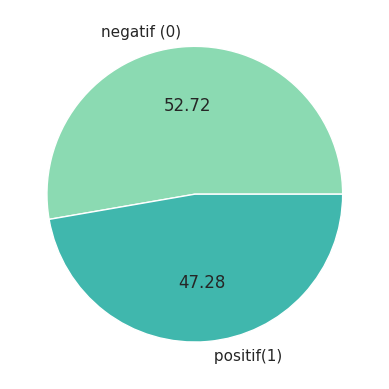

In [ ]:
#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
#Setting a color palette
palette=sns.color_palette('mako_r')
sns.set(palette=palette)
plt.pie(df_train['label'].value_counts(), labels=['negatif (0)',' positif(1)'],autopct="%0.2f")
plt.show()

#Modèle Transformers


In [ ]:
## function for sentiment prediction with a model, a tokenizer and some data

def compute_metrics_trainer(eval_pred):
    metric = evaluate.load("accuracy")
    x= eval_pred
    logits = torch.tensor(x[0])
    labels = x[1]
    predictions = torch.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}



def f_predict_sentiment_review(model, tokenizer, review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    result = int(torch.argmax(result.logits))
    return (result)

def f_predict_sentiment_dataset(dataset, model, tokenizer):
  dataset['prediction'] = dataset['text'].apply(lambda x: f_predict_sentiment_review(model, tokenizer, x[:512]))
  return(dataset)

def f_tokenize_text(examples, tokenizer):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512, return_tensors="tf")

def f_tokenize_data_from_df(df, tokenizer):
  dataset = Dataset.from_pandas(df)
  tokenized_dataset = dataset.map(f_tokenize_text, batched=True, fn_kwargs = {'tokenizer' : tokenizer})
  return(tokenized_dataset)

################################################################################

def f_test_model_hf(model_name, name_new_model) :
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
  model.to(device)
  Train, Test = train_test_split(df_train, test_size=0.25, random_state=0)

  tokenized_train = f_tokenize_data_from_df(Train, tokenizer)
  tokenized_test = f_tokenize_data_from_df(Test, tokenizer)

  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  training_args = TrainingArguments(
    output_dir="./results",    
    num_train_epochs=4,              
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,  
    learning_rate=2e-5,
    warmup_steps=1000, # 1000
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True,
    weight_decay=0.01)

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train,
      eval_dataset=tokenized_test,
      tokenizer=tokenizer,
      data_collator=data_collator,
      compute_metrics = compute_metrics_trainer,
  )

  trainer.train()

  trainer.save_model(name_new_model)

  tokenizer2 = AutoTokenizer.from_pretrained(name_new_model)
  model2 = AutoModelForSequenceClassification.from_pretrained(name_new_model)

  df_test_prediction = f_predict_sentiment_dataset(df_test, model2, tokenizer2)

  metrics = compute_metrics(df_test_prediction['label'], df_test_prediction['prediction'])


  return([df_test_prediction, metrics, model_name])

In [ ]:
resultats = f_test_model_hf('siebert/sentiment-roberta-large-english', 'le_mus_2')

resultats

Map:   0%|          | 0/190903 [00:00<?, ? examples/s]

Map:   0%|          | 0/63635 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.699100,0.691835,0.528891
2,0.696300,0.691691,0.528891
3,0.695300,0.692037,0.528891
4,0.188600,0.207233,0.963605


[                                                    text  label  prediction
 0                                  feel incredibly weepy      0           0
 1                          feeling contented wife mother      1           1
 2      pick novels feel like dropping luggage signing...      1           1
 3      little extra interest right feeling like husba...      1           1
 4      feel become even lot vital high eighty five we...      1           1
 ...                                                  ...    ...         ...
 28278  feel honored motivated share world life changi...      1           1
 28279                  feel like gloaty really delighted      1           1
 28280  feel little energetic one day next several day...      1           1
 28281  feel work experience fell although fantastic o...      1           1
 28282  feel generous mood may give another fan fictio...      1           1
 
 [28283 rows x 3 columns],
 {'accuracy': 0.9652087826609624,
  'precision'

In [ ]:
print(resultats[2], ' a comme score : ', resultats[1])

siebert/sentiment-roberta-large-english  a comme score :  {'accuracy': 0.9652087826609624, 'precision': 0.9614211852048257, 'recall': 0.9730309942305112, 'f1': 0.9671912510002668}
